In [1]:
# dataframe management
import pandas as pd             

# numerical computation
import numpy as np

# visualization library
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   


# import matplotlib and allow it to plot inline
import matplotlib.pyplot as plt
%matplotlib inline
#----------------------------------------------------------------------------------------------------
import pyspark
from datetime import datetime
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import udf,lit

from pyspark.sql import SQLContext
from pyspark.sql.functions import mean

sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
#---------------------------------------------------------------------------------------------------------
# seaborn can generate several warnings, we ignore them
import warnings 
warnings.filterwarnings("ignore")

from bokeh.layouts import gridplot
from bokeh.plotting import figure

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
output_notebook()

Loading BokehJS ...

In [2]:
#reading the notebook
sales_string_date=pd.read_csv('train.csv')
sales = sales_string_date

In [3]:
sales_string_date.describe()

,StoreID,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,Region,NumberOfCustomers,NumberOfSales,Region_AreaKM2,Region_GDP,...,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
count,523021.000000,523021.000000,523021.000000,523021.000000,523021.00000,523021.000000,523021.000000,523021.000000,523021.000000,523021.000000,...,523021.000000,511683.000000,523021.000000,523021.000000,523021.000000,523021.000000,523021.000000,511683.000000,523021.000000,523021.000000
mean,1373.953914,0.029718,0.829714,0.383292,8002.71122,5.713151,259.325073,4057.377536,12381.265718,14050.547848,...,10.273205,12.151025,11.724961,3.737584,51.375624,1012.078435,6.202315,7.223408,0.808278,170.458096
std,216.395820,0.169808,0.375884,0.486189,11537.70753,3.357190,185.857102,2729.630381,9140.692427,2755.425404,...,7.041167,4.978385,5.791031,5.909098,19.284023,8.699236,6.312993,4.899575,2.631428,101.728193
min,1000.000000,0.000000,0.000000,0.000000,47.00000,0.000000,0.000000,0.000000,344.000000,9893.000000,...,-13.000000,0.000000,2.000000,-18.000000,10.000000,970.000000,-15.000000,0.000000,0.000000,-1.000000
25%,1187.000000,0.000000,1.000000,0.000000,1057.00000,3.000000,166.000000,2573.000000,7215.000000,11849.000000,...,4.000000,10.000000,8.000000,-1.000000,36.000000,1007.000000,1.000000,3.000000,0.000000,75.000000
50%,1373.000000,0.000000,1.000000,0.000000,3321.00000,6.000000,251.000000,4020.000000,9643.000000,15017.000000,...,11.000000,11.000000,11.000000,4.000000,51.000000,1013.000000,7.000000,8.000000,0.000000,191.000000
75%,1561.000000,0.000000,1.000000,1.000000,9673.00000,9.000000,345.000000,5538.000000,15566.000000,15931.000000,...,16.000000,14.000000,14.000000,8.000000,66.000000,1018.000000,11.000000,10.000000,0.250000,250.000000
max,1748.000000,1.000000,1.000000,1.000000,85070.00000,10.000000,2206.000000,26641.000000,32221.000000,23931.000000,...,30.000000,31.000000,53.000000,18.000000,100.000000,1038.000000,24.000000,31.000000,58.930000,360.000000


# Imputation of Missing Values

In [4]:
unknown_per_columns = sales.isnull().sum()
unknown_per_columns

StoreID                            0
Date                               0
IsHoliday                          0
IsOpen                             0
HasPromotions                      0
StoreType                          0
AssortmentType                     0
NearestCompetitor                  0
Region                             0
NumberOfCustomers                  0
NumberOfSales                      0
Region_AreaKM2                     0
Region_GDP                         0
Region_PopulationK                 0
CloudCover                     41181
Events                        124098
Max_Dew_PointC                     0
Max_Gust_SpeedKm_h            409947
Max_Humidity                       0
Max_Sea_Level_PressurehPa          0
Max_TemperatureC                   0
Max_VisibilityKm               11338
Max_Wind_SpeedKm_h                 0
Mean_Dew_PointC                    0
Mean_Humidity                      0
Mean_Sea_Level_PressurehPa         0
Mean_TemperatureC                  0
M

We see that Max_Gust_SpeedKm_h has 409947 missing values. We decided not to impute it.
Let's start with imputation of "Events"

In [5]:
null_Events = sales['Events'].isnull()
event_missing = sales[null_Events]
event_missing.describe()


,StoreID,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,Region,NumberOfCustomers,NumberOfSales,Region_AreaKM2,Region_GDP,...,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
count,124098.000000,124098.000000,124098.000000,124098.000000,124098.000000,124098.000000,124098.000000,124098.000000,124098.000000,124098.000000,...,124098.000000,113238.000000,124098.000000,124098.000000,124098.000000,124098.000000,124098.000000,113238.000000,124098.000000,124098.000000
mean,1370.938661,0.025343,0.835316,0.391352,8598.544852,5.708537,262.825307,4087.681623,11494.095529,13693.732615,...,11.397339,15.122741,11.231527,2.934141,40.231946,1015.213468,6.417211,10.525875,0.006096,136.669519
std,215.467924,0.157165,0.370897,0.488055,12179.726740,3.333467,186.579039,2734.958540,8355.170418,2738.751299,...,7.461739,6.641841,5.166388,6.112321,18.089280,7.166503,6.551161,6.132783,0.113929,105.369671
min,1000.000000,0.000000,0.000000,0.000000,47.000000,0.000000,0.000000,0.000000,344.000000,9893.000000,...,-11.000000,2.000000,3.000000,-17.000000,10.000000,986.000000,-12.000000,0.000000,0.000000,-1.000000
25%,1187.000000,0.000000,1.000000,0.000000,1130.000000,3.000000,169.000000,2607.000000,7215.000000,11849.000000,...,6.000000,10.000000,8.000000,-2.000000,25.000000,1011.000000,1.000000,8.000000,0.000000,47.000000
50%,1369.000000,0.000000,1.000000,0.000000,3628.000000,6.000000,254.000000,4027.000000,9337.000000,13155.000000,...,12.000000,13.000000,10.000000,3.000000,37.000000,1016.000000,7.000000,10.000000,0.000000,125.000000
75%,1553.000000,0.000000,1.000000,1.000000,10593.000000,9.000000,349.000000,5557.000000,15566.000000,15931.000000,...,17.000000,19.000000,14.000000,8.000000,53.000000,1020.000000,12.000000,10.000000,0.000000,219.000000
max,1748.000000,1.000000,1.000000,1.000000,85070.000000,10.000000,2206.000000,26641.000000,32221.000000,23931.000000,...,30.000000,31.000000,34.000000,18.000000,100.000000,1038.000000,23.000000,31.000000,4.060000,360.000000


In [6]:
sales['Events'].value_counts()

Rain                           204733
Fog                             67797
Fog-Rain                        50908
Rain-Thunderstorm               21988
Rain-Snow                       18176
Snow                            15433
Fog-Rain-Thunderstorm            8567
Fog-Rain-Snow                    3225
Fog-Snow                         2857
Thunderstorm                     1485
Rain-Hail                        1331
Rain-Snow-Hail                    629
Rain-Hail-Thunderstorm            283
Fog-Rain-Snow-Hail                231
Rain-Snow-Thunderstorm            220
Snow-Hail                         194
Rain-Snow-Hail-Thunderstorm       193
Fog-Rain-Hail-Thunderstorm        178
Fog-Snow-Hail                     169
Fog-Rain-Hail                     169
Fog-Thunderstorm                  157
Name: Events, dtype: int64

By this, we discover that when Event is null the weather is good, from the fact that Precipitationmm mean is almost 0.
Furthermore, all the labels of Events are related to bad weather, that means that when no precipitation occurs the label is null.
We will impute Event by replacing the missing values with "Not Specified" (later).

Now we impute "CloudCover", making a distinction when it misses along with Events and when it misses on its own.

In [7]:
null_Events = sales['Events'].isnull()
null_CloudCover = sales['CloudCover'].isnull()
cloudcover_missing = sales[(null_Events)]
null_Events = sales['Events'].isnull()
event_missing = sales[null_Events]
event_cc_missing = sales[null_CloudCover & null_Events]
cloudcover_missing.shape, event_missing.shape, event_cc_missing.shape 


((124098, 36), (124098, 36), (28274, 36))

There are 28k tuples where both "Events" and "CloudCover" are missing, that means that the weather should be good.
for the remaining (41k-28k) (i.e. where "Events" is not null!) tuples we impute the CloudCoverage.

In [8]:
event_notmissing_cc_missing = sales[null_CloudCover & ~null_Events]
#computing mean where CloudCover is not null
mean_CC = sales["CloudCover"].mean()
event_notmissing_cc_missing["CloudCover"] = event_notmissing_cc_missing["CloudCover"].fillna(mean_CC)
sales = pd.concat([sales[~null_CloudCover | null_Events], event_notmissing_cc_missing])

Then, we impute the remaining rows with CloudCover missing

In [9]:
null_Events = sales['Events'].isnull()
CloudyButNotEvent = sales[null_Events]
#there are some tuples with no Events but with the attribute CloudCover

In [10]:
null_cloudCover = sales[sales['CloudCover'].isnull()]
mean_cloudCover = sales["CloudCover"].mean()
null_cloudCover["CloudCover"] = null_cloudCover["CloudCover"].fillna(mean_cloudCover)

sales = pd.concat([sales[~sales['CloudCover'].isnull()], null_cloudCover])

Now, we impute min,max,mean_VisibilityKm. 

In [11]:
# checking if are all the same rows where visibility data are missing => yes, they are
sales[["Max_VisibilityKm", "Mean_VisibilityKm", "Min_VisibilitykM"]].count()

Max_VisibilityKm     511683
Mean_VisibilityKm    511683
Min_VisibilitykM     511683
dtype: int64

In [12]:
null_visibility = sales[sales['Max_VisibilityKm'].isnull()]
mean_vis_max = sales["Max_VisibilityKm"].mean()
mean_vis_mean = sales["Mean_VisibilityKm"].mean()
mean_vis_min = sales["Min_VisibilitykM"].mean()

null_visibility["Max_VisibilityKm"] = null_visibility["Max_VisibilityKm"].fillna(mean_vis_max)
null_visibility["Mean_VisibilityKm"] = null_visibility["Mean_VisibilityKm"].fillna(mean_vis_mean)
null_visibility["Min_VisibilitykM"] = null_visibility["Min_VisibilitykM"].fillna(mean_vis_min)

sales = pd.concat([sales[~sales['Max_VisibilityKm'].isnull()], null_visibility])

Finally, we impute "Events".

In [13]:
sales=sales.replace(np.nan,'NotSpecified', regex=True)


# Normalization of Numerical Variables

In [14]:
from scipy.stats import skew

# take the numerical features
numeric_feats = sales.dtypes[sales.dtypes != "object"].index

# compute the skewness but only for non missing variables (we already imputed them but just in case ...)
skewed_feats = sales[numeric_feats].apply(lambda x: skew(x.dropna()))

skewness = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.data})
# select the variables with a skewness above a certain threshold

Text(0.5,1,'')

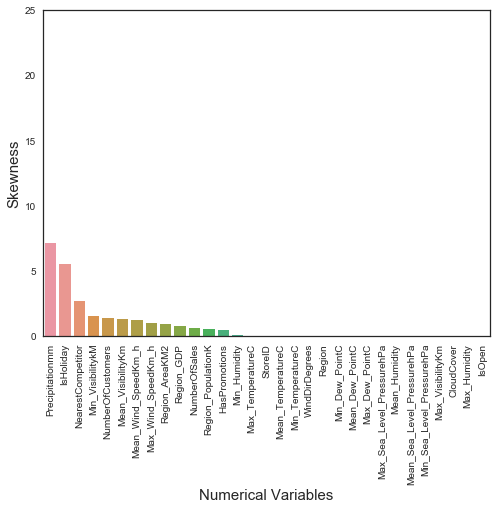

In [15]:
skewness = skewness.sort_values('Skewness', ascending=[0])

f, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation='90')
sns.barplot(x=skewness['Variable'], y=skewness['Skewness'])
plt.ylim(0,25)
plt.xlabel('Numerical Variables', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('', fontsize=15)

In [16]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats.drop('IsHoliday')
sales[skewed_feats.index] = np.log1p(sales[skewed_feats.index])

# Correlation Analysis and Feature Selection

In [17]:
cov=sales[numerical_variables].corr(method='pearson')
cm = sns.clustermap(cov, annot=True, center=0, cmap="Blues", figsize=(25, 25))
cm.cax.set_visible(False)

NameError: name 'numerical_variables' is not defined

By analyzing the correlation, we see that the following variables do not add any additional information. 
Max_Dew_PointC, Min_Dew_PointC, Max_Sea_Level_PressurehPa, Mean_Sea_Level_PressurehPa, Max_Gust_SpeedKm_h
Finally, we drop 'NumberOfCustomers' because is not present in the submission dataset.

In [ ]:
sales=sales.drop(columns=['Max_Dew_PointC','Min_Dew_PointC','Max_Sea_Level_PressurehPa','Mean_Sea_Level_PressurehPa','Max_Gust_SpeedKm_h','NumberOfCustomers'])
sales.shape

# QUI CI VA L'ANALISI STAGIONALE

Flavio ci ha detto che non c'è trend stagionale, quindi droppiamo le date e ci teniamo solo i giorni della settimana

In [ ]:
import datetime as d
def toDate(x):
    parts = [int(el) for el in x.split("/")]
    return d.date(parts[2], parts[1], parts[0])
sales["Date"] = sales["Date"].apply(toDate)
sales['Date'] = sales['Date'].astype("datetime64")
sales['Day_Of_Week'] = sales['Date'].dt.weekday_name
sales=sales.drop(columns=['Date'])

# One Hot Encoding

In [ ]:
sales = pd.get_dummies(sales, columns=['StoreType','Day_Of_Week','Events','AssortmentType',])
sales.head(5)

# First try: MultipleLinear Regression for Region 7

In [ ]:
sales_train = sales.drop(['NumberOfSales'], axis=1)
y = sales['NumberOfSales']

In [ ]:
salesRegion7_train = sales_train.loc[sales_train['Region'] == 7]
salesRegion7_train.drop(columns='Region')
salesRegion7_train.shape

In [ ]:
toGetTarget = sales.loc[sales_train['Region'] == 7]
y = toGetTarget['NumberOfSales']

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


def r2_cv(model, sales_train, y, random_state=12345678):
    r2= cross_val_score(model, sales_train, y, scoring="r2", cv =KFold(10, shuffle=True, random_state=random_state)) 
    return(r2)

def rmse_cv(model, sales_train, y, random_state=12345678):
    rmse= np.sqrt(-cross_val_score(model, sales_train, y, scoring="neg_mean_squared_error", cv =KFold(10, shuffle=True, random_state=random_state)))
    return(rmse)

In [ ]:
model_simple = LinearRegression()
model_simple.fit(salesRegion7_train, y)
yp = model_simple.predict(salesRegion7_train)

# compute R2 for train and using crossvalidation
r2_simple_train = r2_score(y,yp)
r2_xval_simple =  r2_cv(model_simple, salesRegion7_train, y)

# compute RMSE for train and using crossvalidation
rmse_simple_train = mean_squared_error(y,yp,multioutput='raw_values')
rmse_xval_simple =  rmse_cv(model_simple, salesRegion7_train, y)

print("Linear Regression")
print("==================================================")
print("\t                  Train R2=%.3f"%(r2_simple_train))
print("\t10-fold Crossvalidation R2=%.3f"%(r2_xval_simple.mean()))
print("\t                  Train RMSE=%.3f"%(rmse_simple_train))
print("\t10-fold Crossvalidation RMSE=%.3f"%(rmse_xval_simple.mean()))